<a href="https://colab.research.google.com/github/luisf10/MCCP/blob/main/FinalMCC607.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***EXAMEN FINAL DE APRENDIZAJE AUTOMATICO:***

In [ ]:
#Audio descargado por 8 horas,el cual ya esta.Asi que lo obvio.
#Crear carpetas

***Paso2:  Convierte MP3 a WAV y segmenta el audio a intervalos de 1 seg, de ser necesario instale librerias con pip***

In [3]:
#Instalar con pip todos las librerias que sean necesarias
pip install pydub

In [4]:
import librosa
import soundfile as sf
from os import path 
from pydub import AudioSegment 

#Declaro la ruta origen del mp3
rutamp3="audio_ori//audio_ori.mp3"
rutawav="audio_ori//audio_ori.wav"

#...........................................................
def converMP3toWAV(filemp3,filewav):
    sound = AudioSegment.from_mp3(filemp3) 
    sound.export(filewav, format="wav") 
#...........................................................
def segmentadoAudio(filewav):
    data,fs=librosa.load(filewav) #data y frec de muestreo
    n=int(len(data)/fs) #numero de segundos de duracion
    #Segmentado de audio en la carpeta audio_seg
    for i in range(n):
        data1=data[i*fs:(i+1)*fs]
        nameaudio="audio_seg//audio_"+str("%05d" % i)+".wav"
        sf.write(nameaudio, data1,fs, subtype='PCM_24')
#............................................................
#Ejecutando el codigo:
converMP3toWAV(rutamp3,rutawav) #Convierte el audio MP3 a WAV
segmentadoAudio(rutawav)        #Segmenta el audio WAV

***Paso3: Renombra los audios segmentados,en funcion a las etiquetas del excel. Es necesario que suba el excel de etiquetas en etiquetaslogan***

In [12]:
import librosa
import soundfile as sf
from os import path 
from pydub import AudioSegment 
import matplotlib.pyplot as plt
import numpy as np 
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from scipy.stats import entropy
import glob
import pandas as pd 
import random
import  re
import os
import sys

#..........................................................................

#..........................................................................
datafile="etiquetaslogan//etiquetadoslogan.xlsx"
# lee los datos, con id = paciente
dataset_ori  = pd.read_excel(datafile, sheet_name='Hoja1')  # lee dataset, con index
dataset_ori  = dataset_ori.to_numpy()  
#print(dataset_ori[:,0])
#......................................................................

def getIDfilename(filename):
    return re.search(r'\d+', filename).group(0)
# ruta = [".\\audio_seg\\"+f+"\\" for f in sorted(os.listdir(".\\audio_seg"))]
#............................................................................
ruta="audio_seg//"
for filename in os.listdir(ruta):
    filename2=getIDfilename(filename)
    k=int(filename2) #Ubica el numero de segmento
    etiqueta=dataset_ori[k,2] #Busca la etiqueta
    filename3="audio_"+filename2+"_"+str(etiqueta)+".wav" #Agrega al nuevo nombre la etiqueta
    #Renombramos los files:
    os.rename(ruta+filename,ruta+filename3)

***Paso 4: Visualizar los datos de Fourier,Spectral,MFCC de un audio cualquiera segmentado.***

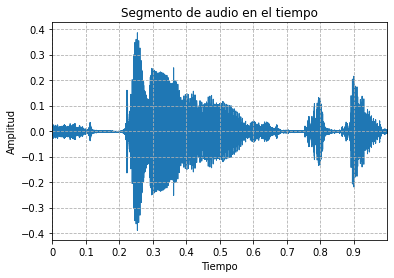

frecuencia de a la que esta la amplitud maxima de la FFT=[263.01192798] Hz


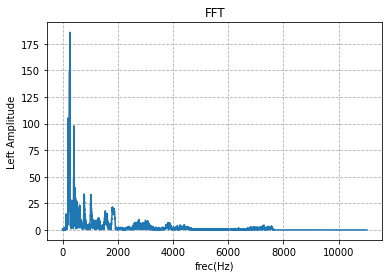

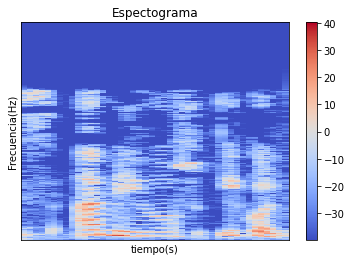

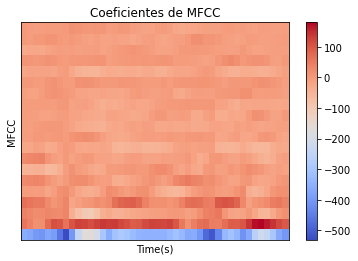

In [10]:
import librosa,librosa.display
import matplotlib.pyplot as plt
import numpy as np 


#Declaro la ruta origen del mp3
#Escribes cualquier segmento de audio de la carpeta audio_seg
#se le aplicara el fourier,se graficara el espectro y todo lo demas
#................................................................
#Quita el comentario y ubica el nombre wav
filewav="audio_seg//audio_00011_4.wav"
#................................................................
data,fs=librosa.load(filewav)


librosa.display.waveplot(data,sr=fs)

plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Segmento de audio en el tiempo')
plt.grid('on',linestyle='--')
plt.show()
#plt.ylim([-1,1])

#...............................................
#Transformada de Fourier:FFT
fft=np.fft.fft(data)
magnitude=np.abs(fft)
frequency=np.linspace(0,fs,len(magnitude))

left_frequency=frequency[:int(len(frequency)/2)]
left_magnitude=magnitude[:int(len(frequency)/2)]

left_frequency_max=left_frequency[left_magnitude==max(left_magnitude)]
print('frecuencia de a la que esta la amplitud maxima de la FFT={0} Hz'.format(left_frequency_max))

plt.plot(left_frequency,left_magnitude)
plt.xlabel("frec(Hz)")
plt.ylabel("Left Amplitude")
plt.title("FFT")
plt.grid('on',linestyle='--')
plt.show()
#...............................................
#stft:Spectogram
#obs: fs=22050 Hz
#obs: duracion: n=1
n_fft=2048
hop_length=512

stft=librosa.core.stft(data,hop_length=hop_length,n_fft=n_fft)
spectogram=np.abs(stft)

log_spectogram=librosa.amplitude_to_db(spectogram)
# librosa.display.specshow(spectogram,sr=fs,hop_length=hop_length)
librosa.display.specshow(log_spectogram,sr=fs,hop_length=hop_length)

plt.xlabel("tiempo(s)")
plt.ylabel("Frecuencia(Hz)")
plt.title("Espectograma")
plt.colorbar()
plt.show()
#................................................
#MFCCs:
MFFCs=librosa.feature.mfcc(data,n_fft=n_fft,hop_length=hop_length,n_mfcc=20)
#20,usualmente es 13
librosa.display.specshow(MFFCs,sr=fs,hop_length=hop_length)

plt.xlabel("Time(s)")
plt.ylabel("MFCC")
plt.title("Coeficientes de MFCC")
plt.colorbar()
plt.show()
##


***Paso5: Extraer las caracteristicas de cada archivo segmentado wav, y almacenarlos en un csv (dataset)***

In [13]:
import librosa,librosa.display
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from scipy.stats import entropy
import glob
import random
import  re
import os
import sys

#.....................................................................
# Funcion que ordena todos los files.  
def ordenaNombreFile(path):
    filenames=glob.glob(path+'*.wav')
    r = re.compile(r"(\d+)")
    filenames.sort(key=lambda x: int(r.search(x).group(1)))
    return filenames

#....................................................................
def valorRMS(x):
    n=len(x)
    s=0
    for i in x:
        s=s+i**2
    s=s/n
    s=s**0.5
    return s
#....................................................................
######################################################################
#.....................................................................
#Esta funcion obtiene las 63 caracteristicas de un solo segmento de audio
#Retorna un vector de longitud 63
def getFeatures(filewav):
    #20 coeficientes de MFCC
    #12 coeficientes de chroma
    #7 coeficientes de contaste
    #7 coeficientes de Mel
    #6 coeficientes de tonnetz
    #1 maximo:
    #1 rms
    #1 interv interquartil
    #1 kurtosis
    #1 skew
    #1 std
    #1 median
    #1 mean
    #1 std abs
    #1 freq a la max amplitud en FFT
    #1 mag maxima de la FFT
    #Total:==>63 caracteristicas
    #Etiqueta==>1:
    #Array de 64 de longitud
    #-------------------------------------------------------
    data,fs=librosa.load(filewav)
    n=int(len(data)/fs)
    fft=np.fft.fft(data)
    magnitude=np.abs(fft)
    frequency=np.linspace(0,fs,len(magnitude))
    left_frequency=frequency[:int(len(frequency)/2)]
    left_magnitude=magnitude[:int(len(frequency)/2)]
    
    n_fft=2048
    hop_length=512
    #Short Transform Fourier
    stft=np.abs(librosa.stft(data))
    #Coeficientes de Mel
    MFCC_audio=np.mean(librosa.feature.mfcc(y=data,sr=fs,n_mfcc=20).T,axis=0)
    #Coeficientes del chroma:
    chroma_audio=np.mean(librosa.feature.chroma_stft(S=stft,sr=fs).T,axis=0)
    #coeficientes del contraste de audio:
    contraste_audio = np.mean(librosa.feature.spectral_contrast(S=stft, sr=fs).T,axis=0)
    #coeficientes de Mel:
    mel_audio = np.mean(librosa.feature.spectral_contrast(S=stft, sr=fs).T,axis=0)
    #coeficientes del tonnetz:
    tonnetz_audio = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data),sr=fs).T,axis=0)
    #Maximo valor del audio:
    maximo_audio=max(abs(data))
    #valor RMS del audio:
    rms_audio=valorRMS(data)
    #Intervalo interquartil:
    interquartil_audio=np.quantile(data,0.75)-np.quantile(data,0.25)
    #Kurtosis:
    kurtosis_audio=kurtosis(data)
    #skew:
    skew_audio=skew(data)
    #std:
    std_audio=np.std(data)
    #median:
    median_audio=np.median(data)
    #mean:
    mean_audio=np.mean(data)
    #std abs:
    stdabs_audio=np.mean(np.absolute(data - np.mean(data)))
    #FFT: Freq a la que se da la maxima amplitud
    left_frequency_max=left_frequency[left_magnitude==max(left_magnitude)]
    #Maxima amplitud a cierta frecuencia
    left_magnitude_max=max(left_magnitude)
    #..................................................................
    #Agregando a feature:
    feature=[]
    feature=np.append(feature,MFCC_audio)
    feature=np.append(feature,chroma_audio)
    feature=np.append(feature,contraste_audio)
    feature=np.append(feature,mel_audio)
    feature=np.append(feature,tonnetz_audio)
    feature=np.append(feature,maximo_audio)
    feature=np.append(feature,rms_audio)
    feature=np.append(feature,interquartil_audio)
    feature=np.append(feature,kurtosis_audio)
    feature=np.append(feature,skew_audio)
    feature=np.append(feature,std_audio)
    feature=np.append(feature,median_audio)
    feature=np.append(feature,mean_audio) 
    feature=np.append(feature,stdabs_audio)
    feature=np.append(feature,left_frequency_max)
    feature=np.append(feature,left_magnitude_max)



    return feature
#......................................................................
#######################################################################
#.....................................................................
#Esta funcion genera una cabecera para todas las caracteristicas
def setheaderAudio():
    
    col_mfcc=[]
    for i in np.arange(1,21):
        col_mfcc=np.append(col_mfcc,"MFCC_"+str(i))

    col_chroma=[]
    for i in np.arange(1,13):
        col_chroma=np.append(col_chroma,"CHRO_"+str(i))


    col_contrast=[]
    for i in np.arange(1,8):
        col_contrast=np.append(col_contrast,"CONTR_"+str(i))


    col_mel=[]
    for i in np.arange(1,8):
        col_mel=np.append(col_mel,"MEL_"+str(i))


    col_tonnetz=[]
    for i in np.arange(1,7):
        col_tonnetz=np.append(col_tonnetz,"TON_"+str(i))

    col_max="max"
    col_rms="rms"
    col_iiq="interv_iq"
    col_kurt="kurtosis"
    col_skew="skew"
    col_std="std"
    col_median="median"
    col_mean="mean"
    col_stdabs="std_abs"
    col_freqm="freq_max"
    col_magm="mag_max"
    col_slogan_id="slogan_id"


    header=[]
    header=np.append(header,col_mfcc)
    header=np.append(header, col_chroma)
    header=np.append(header,col_contrast)
    header=np.append(header,col_mel)
    header=np.append(header,col_tonnetz)
    header=np.append(header,col_max)
    header=np.append(header,col_rms)
    header=np.append(header,col_iiq)
    header=np.append(header,col_kurt)
    header=np.append(header,col_skew)
    header=np.append(header,col_std)
    header=np.append(header,col_median)
    header=np.append(header,col_mean)
    header=np.append(header,col_stdabs)
    header=np.append(header,col_freqm)
    header=np.append(header,col_magm)
    header=np.append(header,col_slogan_id)
    

    return header
#....................................................................
#.....................................................................
######################################################################
######################################################################
#.....................................................................
########## EJECUCION DEL PROGRAMA ####################################
#Ruta donde se encuentran todos los wav divididos.
ruta="audio_seg//"
#......................................................................
#Ordena los nombres:...................................................
filenames=ordenaNombreFile(ruta)
#......................................................................
#Extraccion de caracteristicas de un archivo de audio:
vectordataset=[] #Declaramos vacio el vector dataset
#iteracion ordenada para cada archivo wav
for file in filenames:
    feature=getFeatures(file)     #obtiene las 63 caracteristicas de un wav
    clase=(file.split("_")[3]).split(".")[0] #extrae la etiqueta del wav
    feature=np.append(feature,clase) #Obtiene un vector de longitud 64 
    vectordataset.append(feature) #almacena en una fila de vectordataset
#......................................................................
#Escribir el vector dataset en un csv final no escalado
dataset=pd.DataFrame(vectordataset)

dataset.to_csv("dataset//datasetSlogan.csv",header=setheaderAudio(),index=False)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=690
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=345
  n_fft, y.shape[-1]


***Paso 6: Visualizacion de los datos: Aqui se limpian los nulos, infinitos. Y se debe escalar el CSV, para tenerlo listo y mandarlo al sistema de entrenamiento.***

In [15]:
#Paso 6: Visualizacion de los datos:
import librosa,librosa.display
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from scipy.stats import entropy
import glob
import random
import  re
import os
import sys

filedataset="dataset//datasetSlogan.csv"

df=pd.read_csv(filedataset)

print(df.describe())

           MFCC_1      MFCC_2     MFCC_3  ...    freq_max     mag_max  slogan_id
count   48.000000   48.000000  48.000000  ...   48.000000   48.000000  48.000000
mean  -291.646240  145.318166 -32.037262  ...  369.704267  295.069597   2.250000
std    108.582697   30.068368  29.417738  ...  238.265377  140.596316   1.768519
min   -653.343750   72.226555 -94.511406  ...   73.003311    8.728778   0.000000
25%   -344.077774  127.759922 -56.180507  ...  195.758878  201.486677   1.000000
50%   -296.839615  150.495850 -28.648716  ...  288.013062  285.274977   2.000000
75%   -236.637863  168.309101  -7.742178  ...  519.023538  383.066902   4.000000
max   -102.644608  193.921295  16.643856  ...  881.039956  663.414667   9.000000

[8 rows x 64 columns]
